In [ ]:
%%capture
# Install 
!pip install git+https://github.com/cschlick/PhenixML.git
# clone for the data files
!git clone https://github.com/cschlick/PhenixML.git 

In [1]:
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import tqdm
from collections import defaultdict


sys.path.append("PhenixML")
from phenixml.fragments.fragments import Fragment, MolContainer
from phenixml.fragmentation.fragmenters import BondFragmenter, AngleFragmenter
from phenixml.labelers.fragment_labelers import BondFragmentLabeler,AngleFragmentLabeler
from phenixml.featurizers.atom_featurizers import RDKIT_Fingerprint

from phenixml.graphs.molgraph import MolGraph
from phenixml.graphs.molgraph_dataset import MolGraphDataset

from phenixml.utils.torch_utils import to_np
from phenixml.visualization.plotting import plot_geom_eval
from phenixml.visualization.fragment_display import FragmentDisplay
show = FragmentDisplay()

Using backend: pytorch


In [4]:
# get molecules
mol_dir = "PhenixML/data/geostd_mol/"
containers = MolContainer.from_folder(mol_dir,suffix=".mol",removeHs=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16151/16151 [00:38<00:00, 415.60it/s]


In [5]:
# fragment, featurize,label, build graphs
molgraphs = MolGraph.from_containers(containers,
                         fragmenter=AngleFragmenter(exclude_elements=[]),
                         labeler=AngleFragmentLabeler(),skip_failures=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16150/16150 [05:46<00:00, 46.58it/s]


In [6]:
# set up dataset, train/test split
dataset= MolGraphDataset(molgraphs)
dataset_train, dataset_test = dataset.train_test_split(test_fraction=0.2)
batches = list(dataset_train.batches(batch_size=10000))

In [7]:
# make model
from phenixml.models.message_passing import MessagePassing
from phenixml.models.readout import ReadoutLinearJanossy

# settings
gpuid = 1
n_units = 128
n_layers_mp = 3
fragment_size = 3
feature_units = molgraphs[0].heterograph.nodes["atom"].data["h0"].shape[1]


# Set up message passing
config = []
for n_layer in range(n_layers_mp):
  config+=[n_units,"relu"]

message_passing = MessagePassing(
    feature_units=feature_units,
    config=config) 


# Set up readout
n_layers_readout = 3
config = []
for n_layer in range(n_layers_readout):
  config+=[n_units,"relu"]
  
readout = ReadoutLinearJanossy(
    in_features=n_units, 
    config=config,
    out_features={"pred":1},
    fragment_size = fragment_size)

# Sequential message passing, readout
model = nn.Sequential(message_passing,readout)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)
metric = torch.nn.MSELoss()

if gpuid is not None:
  model = model.to("cuda:"+str(gpuid))

In [8]:
# Training loop
epoch_losses = []
n_epoch=2000

for epoch in tqdm.tqdm(range(n_epoch)):
  batch_losses = []
  for batch in batches:
    if gpuid is not None:
      batch = batch.to("cuda:"+str(gpuid))
    g = model(batch)
    loss = metric(g.nodes["fragment"].data["ref"],
                  g.nodes["fragment"].data["pred"])
    opt.zero_grad()
    loss.backward()
    opt.step()
    batch_losses.append(loss.item())

  epoch_losses.append(np.mean(batch_losses))
  


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [10:52<00:00,  3.06it/s]


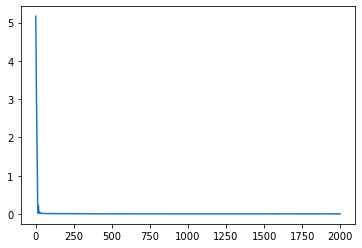

In [9]:
plt.plot(epoch_losses)

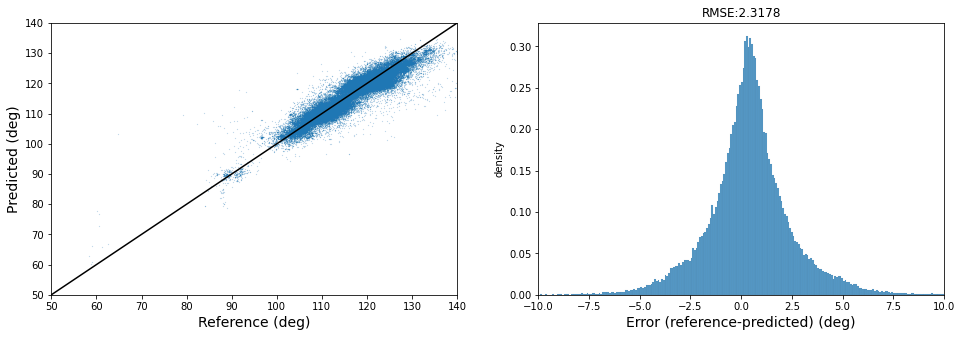

In [10]:
if gpuid is not None:
  model = model.to("cpu")
test_batch = model(dataset_test.heterograph)
a,b = (test_batch.nodes["fragment"].data["ref"], 
       test_batch.nodes["fragment"].data["pred"])
a,b = to_np(a).flatten(),to_np(b).flatten()
a,b = np.degrees(a), np.degrees(b)
plot_geom_eval(a,b,mode="angle")

In [49]:
# evaluate
mol_containers = defaultdict(list)
for i,fragment in enumerate(dataset_test.fragments):
  
  ref,pred = (test_batch.nodes["fragment"].data["ref"][i].item(),
              test_batch.nodes["fragment"].data["pred"][i].item())
  ref,pred = np.degrees(ref),np.degrees(pred)
  error = np.abs(ref-pred)
  mol_containers[fragment.mol_container].append(error)
  
worst = np.array([np.max(value) for key,value in mol_containers.items()])
cutoff = 10
n_ok = (worst<=cutoff).sum()
n_bad = (worst>cutoff).sum()
print("Number of mols in test set:",len(mol_containers))
print("Mols better than cutoff:",n_ok)
print("Mols worse than cutoff:",n_bad)

In [57]:
worst = sorted(worst)

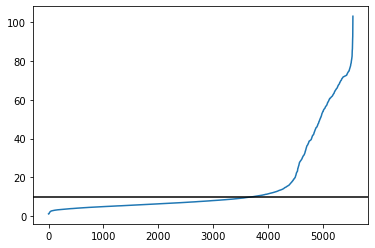

In [63]:
plt.plot(worst)
plt.axhline(y=10,color="black")

In [69]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
readout.sequential_3.register_forward_hook(get_activation("sequential_3"))
output = model(test_batch)
rep = to_np(activation["sequential_3"])

In [79]:
import umap

In [81]:
fit = umap.UMAP()

In [ ]:
%time u = fit.fit_transform(rep)

In [ ]:
# knn demo

In [ ]:
model.fc2.register_forward_hook(get_activation('fc2'))
x = torch.randn(1, 25)
output = model(x)
print(activation['fc2'])

# Check outliers


In [11]:
fragments = dataset_test.fragments

In [12]:
ref = np.degrees(to_np(test_batch.nodes["fragment"].data["ref"][:,0]))
pred = np.degrees(to_np(test_batch.nodes["fragment"].data["pred"][:,0]))
error = np.abs(ref-pred)

In [28]:
bad = set(np.where(error>30)[0])
#ref_sel = set(np.where(ref>65)[0])
pred_sel = set(np.where(b>130)[0])
sels = list(bad.intersection(*[bad,pred_sel]))


177944

In [68]:
sel = np.argmax(error)
print("Ref:",a[sel],"Pred:",b[sel])
fragment = fragments[sel]
show.show_fragment(fragment,show3d=True)

Ref: 177.21771 Pred: 74.162346


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [35]:
sel = sels[300]
print("Ref:",a[sel],"Pred:",b[sel])
fragment = fragments[sel]
show.show_fragment(fragment,show3d=True)

Ref: 164.75269 Pred: 134.2014


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol